Gamma Oscillation Analysis

This study examines whether the simulated neural network generates gamma-band oscillations (20–80 Hz) and how these oscillations depend on model parameters.

The simulation produces a local field potential (LFP), representing the combined electrical activity of nearby neurons. To identify rhythmic activity, the LFP is analyzed in the frequency domain using the Fast Fourier Transform (FFT). The signal is divided into 1-second segments, detrended, windowed, and averaged to obtain a stable power spectrum.

Within the gamma range, the dominant oscillation frequency is identified as the frequency with maximal power. The strength of the oscillation is measured as the average power within a ±3 Hz band around this peak.

This procedure is repeated across different values of NMDA conductance onto inhibitory neurons (gNI) and external current applied to inhibitory neurons (Iapp_I). The results are visualized using line plots and heatmaps to reveal how oscillation frequency and power vary across parameter space. Time-domain traces and spectrograms are also used to confirm that the oscillations are stable over time.

Overall, this analysis characterizes when the network produces strong, coherent gamma rhythms and how these rhythms change with inhibitory drive.


Reference

Kirli, K. K., Ermentrout, G. B., & Cho, R. Y. (2014). Computational study of NMDA conductance and cortical oscillations in schizophrenia. Frontiers in Computational Neuroscience, 8:133. https://doi.org/10.3389/fncom.2014.00133

In [3]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


from src.utilities import run_one_point


we define a function that finds the average strength of different frequencies in the LFP signal, i.e. the Local Field Potential, by looking at it one second at a time.

LFP: is a signal that represents the combined electrical activity of many nearby neurons, measured outside the cells

In [4]:
import os
# Prevent oversubscription (many processes × many BLAS threads)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"




# ----------------------------
# Parameters (edit as needed)
# ----------------------------
g_values     = np.linspace(0.0, 0.06, 7)   # NMDA conductance
IappI_values = np.linspace(0.0, 0.8, 9)    # inhibitory current

dt_ms = 0.05
T_ms = 10000.0
rng_seed = 0
alpha_n_per_ms = 0.5

# Build all (gg, IappI) combinations
tasks = [(gg, IappI) for IappI in IappI_values for gg in g_values]

# Run in parallel: n_jobs=-1 uses all logical cores
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(run_one_point)(gg, IappI, dt_ms, T_ms, rng_seed, alpha_n_per_ms)
    for gg, IappI in tasks
)

# ----------------------------
# Pack results into heatmaps
# ----------------------------
freq_map  = np.full((len(IappI_values), len(g_values)), np.nan, dtype=float)
power_map = np.full((len(IappI_values), len(g_values)), np.nan, dtype=float)

g_index = {float(g): j for j, g in enumerate(g_values)}
I_index = {float(I): i for i, I in enumerate(IappI_values)}

lfp_map = {}

for gg, IappI, f0, P0, lfp in results:
    i = I_index[IappI]
    j = g_index[gg]

    freq_map[i, j] = f0
    power_map[i, j] = P0
    lfp_map[(i, j)] = lfp




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  39 out of  63 | elapsed:  6.5min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  46 out of  63 | elapsed:  6.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  53 out of  63 | elapsed:  7.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  60 out of  63 | elapsed:  7.7min remaining:   22.9s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:  7.7min finished


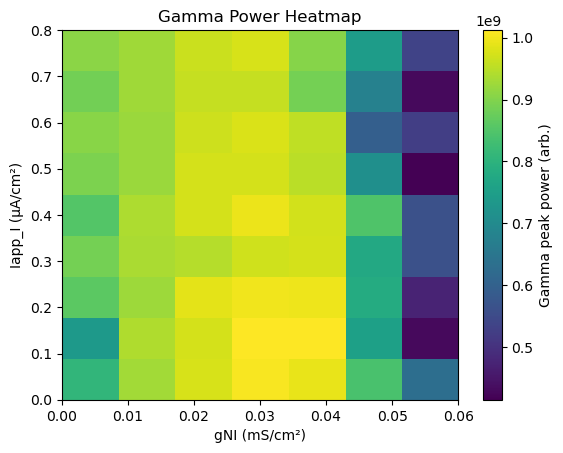

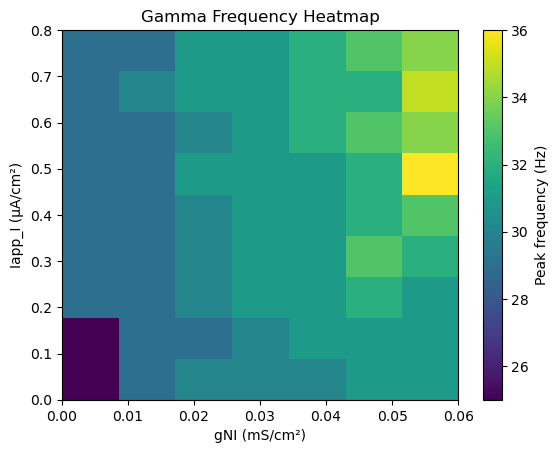

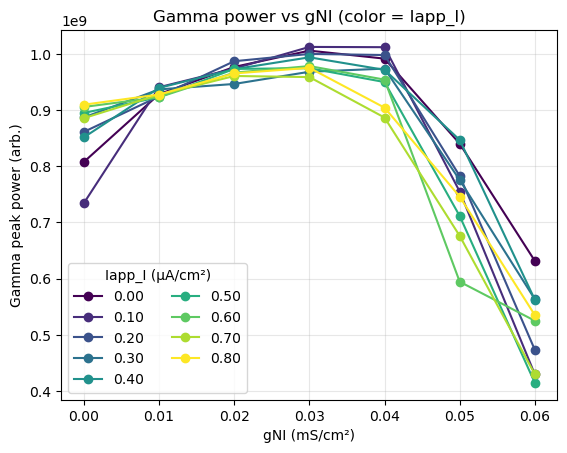

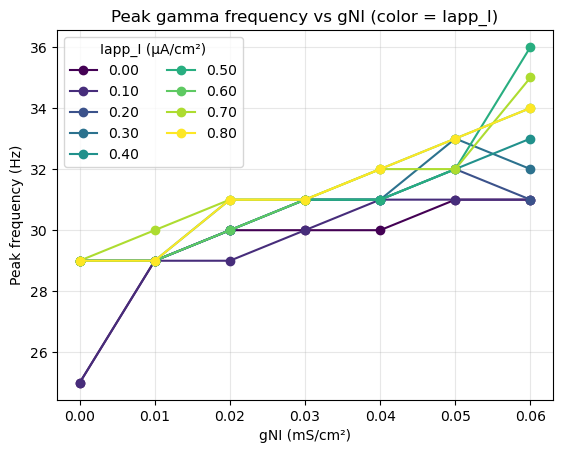

In [5]:
# ----------------------------
# Plot heatmaps
# ----------------------------
plt.figure()
plt.imshow(
    power_map,
    aspect="auto",
    origin="lower",
    extent=[g_values[0], g_values[-1], IappI_values[0], IappI_values[-1]]
)
plt.colorbar(label="Gamma peak power (arb.)")
plt.xlabel("gNI (mS/cm²)")
plt.ylabel("Iapp_I (µA/cm²)")
plt.title("Gamma Power Heatmap")
plt.show()

plt.figure()
plt.imshow(
    freq_map,
    aspect="auto",
    origin="lower",
    extent=[g_values[0], g_values[-1], IappI_values[0], IappI_values[-1]]
)
plt.colorbar(label="Peak frequency (Hz)")
plt.xlabel("gNI (mS/cm²)")
plt.ylabel("Iapp_I (µA/cm²)")
plt.title("Gamma Frequency Heatmap")
plt.show()



cmap = plt.cm.viridis
g_values_plot = np.linspace(0.0, 0.06, power_map.shape[1])

plt.figure()
for i, IappI in enumerate(IappI_values):
    plt.plot(
        g_values_plot,
        power_map[i, :],
        marker="o",
        color=cmap(i / (len(IappI_values) - 1)),
        label=f"{IappI:.2f}"
    )

plt.legend(title="Iapp_I (µA/cm²)", ncol=2)
plt.xlabel("gNI (mS/cm²)")
plt.ylabel("Gamma peak power (arb.)")
plt.title("Gamma power vs gNI (color = Iapp_I)")
plt.grid(True, alpha=0.3)
plt.show()


cmap = plt.cm.viridis   # or viridis / plasma / turbo / inferno

g_values_plot = np.linspace(0.0, 0.06, freq_map.shape[1])  # matches columns

plt.figure()
for i, IappI in enumerate(IappI_values):
    plt.plot(
        g_values_plot,
        freq_map[i, :],              # <-- frequency row
        marker="o",
        color=cmap(i / (len(IappI_values) - 1)),
        label=f"{IappI:.2f}"
    )

plt.legend(title="Iapp_I (µA/cm²)", ncol=2)
plt.xlabel("gNI (mS/cm²)")
plt.ylabel("Peak frequency (Hz)")
plt.title("Peak gamma frequency vs gNI (color = Iapp_I)")
plt.grid(True, alpha=0.3)
plt.show()


In [6]:
dt=0.05

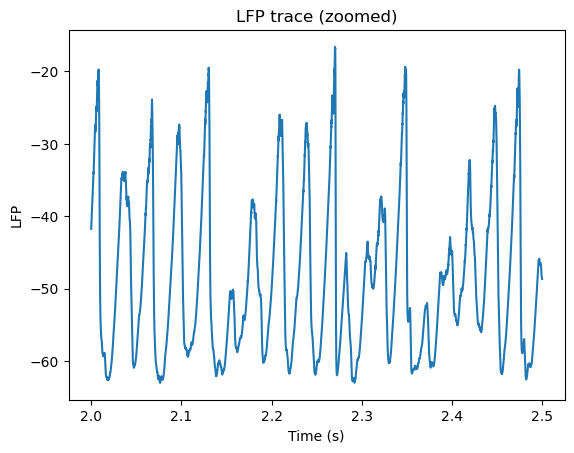

In [7]:

start_s = 2.0      # seconds (after transient)
duration_s = 0.5   # window length

start = int(start_s * 1000 / dt)
end   = int((start_s + duration_s) * 1000 / dt)

t = np.arange(start, end) * dt / 1000

plt.figure()
plt.plot(t, lfp[start:end])
plt.xlabel("Time (s)")
plt.ylabel("LFP")
plt.title("LFP trace (zoomed)")
plt.show()



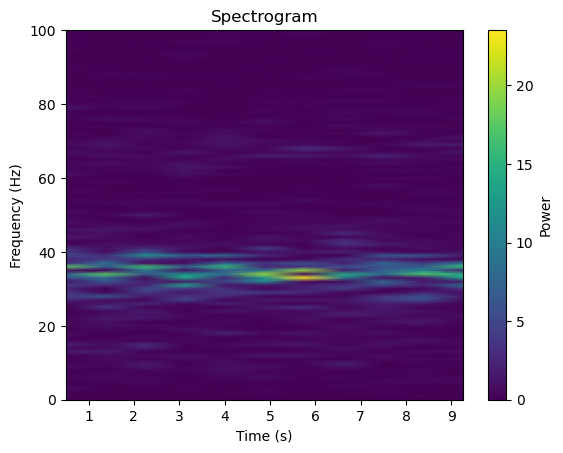

In [8]:
from scipy.signal import spectrogram

fs = 1.0 / (dt * 1e-3)

f, t, S = spectrogram(lfp, fs=fs, nperseg=int(fs))

plt.pcolormesh(t, f, S, shading='gouraud')
plt.ylim(0, 100)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram')
plt.colorbar(label="Power")
plt.show()
